In [2]:
%matplotlib inline

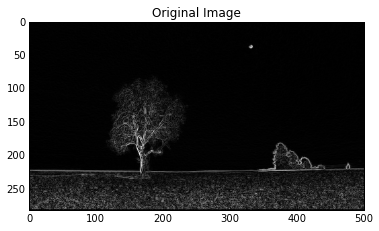

In [41]:
from skimage import data, draw
from skimage import transform, util
import numpy as np
from skimage import filters, color
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance

hl_color = np.array([0, 1, 0])
img = Image.open("countryside.jpg") 
#img = data.rocket()
img = util.img_as_float(img)
E = filters.sobel(color.rgb2gray(img))

plt.title('Original Image')
plt.imshow(E)

In [61]:
rows, columns = np.where(E == E.max())
print rows, columns
E[280][150]

[194] [163]


0.0

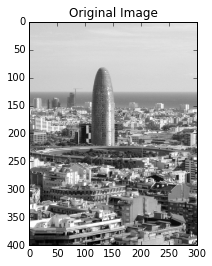

In [24]:
from skimage import data, draw
from skimage import transform, util
import numpy as np
from skimage import filters, color
from matplotlib import pyplot as plt


hl_color = np.array([0, 1, 0])


img = util.img_as_float(img)
eimg = filters.sobel(color.rgb2gray(img))

plt.title('Original Image')
plt.imshow(img)

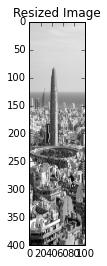

In [25]:
resized = transform.resize(img, (img.shape[0], img.shape[1] - 200))
plt.figure()
plt.title('Resized Image')
plt.imshow(resized)

In [26]:
out = transform.seam_carve(img, eimg, 'vertical', 200)
plt.figure()
plt.title('Resized using Seam-Carving')
plt.imshow(out)

AttributeError: 'module' object has no attribute 'seam_carve'